<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с значением *F1*-мерыне менее 0.59. Проверим *F1*-меру на тестовой выборке.

Дополнительно измерим *AUC-ROC*.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
#! pip install imblearn

In [2]:
import pandas as pd

import numpy as np

import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, roc_curve, confusion_matrix, recall_score, precision_score, roc_auc_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.svm import SVC

import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

import imblearn
from imblearn.over_sampling import SMOTE

import phik
from phik import report
from phik.report import plot_correlation_matrix

import warnings

In [3]:
warnings.filterwarnings("ignore")

In [4]:
pd.options.mode.chained_assignment = None

In [5]:
df = pd.read_csv('/datasets/Churn.csv')
display(df.head())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Данные в основном в формате чисел, за исключением фамилии клиента, страны проживания, пола.  
Присутствует около 10% пропусков в данных срока жизни клиента в банке.

In [7]:
# Заменим пропуски медианным значением по комбинации Age + Geography

for age in df['Age'].unique():
    for geo in df['Geography'].unique():
        df.loc[(df['Age'] == age) & (df['Geography'] == geo) & (df['Tenure'].isna()), 'Tenure'] = \
        df.loc[(df['Age'] == age) & (df['Geography'] == geo), 'Tenure'].median()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


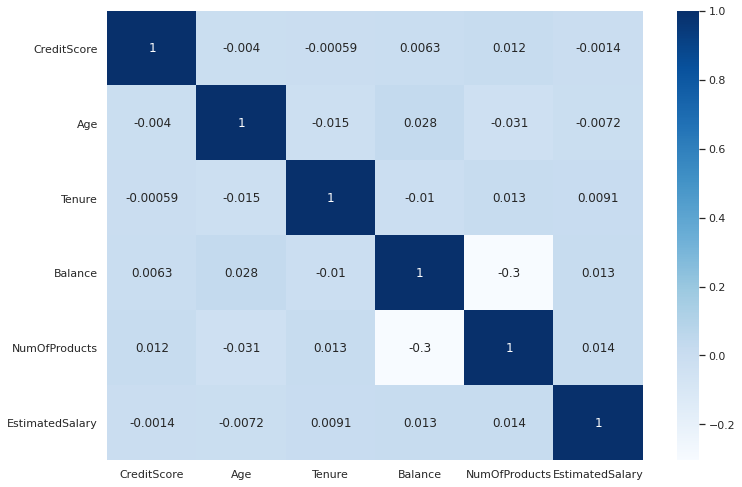

In [9]:
sns.set(rc={'figure.figsize':(12, 8.27)})
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
corr = df[numeric].corr()
sns.heatmap(corr, cmap="Blues", annot=True);

Мультиколлинеарность отсутствует

In [10]:
# Избавимся от столбцов с индексами и фамилиями клиентов (присутствутет уникальный идентификатор CustomerId)

df = df.drop(['RowNumber', 'Surname'], axis=1)

In [11]:
# Сделаем столбцец с уникальным идентификатором индексом таблицы

df = df.set_index('CustomerId')
print(df.head())

            CreditScore Geography  Gender  Age  Tenure    Balance  \
CustomerId                                                          
15634602            619    France  Female   42     2.0       0.00   
15647311            608     Spain  Female   41     1.0   83807.86   
15619304            502    France  Female   42     8.0  159660.80   
15701354            699    France  Female   39     1.0       0.00   
15737888            850     Spain  Female   43     2.0  125510.82   

            NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  
CustomerId                                                                     
15634602                1          1               1        101348.88       1  
15647311                1          0               1        112542.58       0  
15619304                3          1               0        113931.57       1  
15701354                2          0               0         93826.63       0  
15737888                1          1

In [12]:
# Разобьём данные на обучающую, валидационную и тестовую выборки, переведём категориальные признаки в цифровые, 
# а также масштабируем численные признаки.

df_ohe = pd.get_dummies(df, drop_first=True)
features = df_ohe.drop('Exited', axis=1)
target = df_ohe['Exited']

#features = df.drop('Exited', axis=1)
#target = df['Exited']

features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, target, test_size=0.4, random_state=11363, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test, target_valid_test, test_size=0.5, random_state=11363, stratify=target_valid_test)
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

#encoder = OneHotEncoder(handle_unknown ='ignore')
#encoder.fit(features_train)
#features_train = encoder.transform(features_train)
#features_valid = encoder.transform(features_valid)
#features_test = encoder.transform(features_test)

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(f'Формат обучающих выборок: {features_train.shape}, {target_train.shape}')
print(f'Формат валидационных выборок: {features_valid.shape}, {target_valid.shape}')
print(f'Формат тестовых выборок: {features_test.shape}, {target_test.shape}')

Формат обучающих выборок: (6000, 11), (6000,)
Формат валидационных выборок: (2000, 11), (2000,)
Формат тестовых выборок: (2000, 11), (2000,)


In [13]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
CustomerId,,,,,,,,,,,
15660768,-0.484203,0.113919,-1.442161,0.110878,1,0,0,-1.099484,0,0,1
15660980,-0.557295,-0.078620,0.368727,0.612687,2,1,1,-1.293613,0,1,1
15574584,0.204950,-0.559969,1.093082,0.788182,1,1,1,-1.043039,0,0,1
15777033,-1.319541,-0.945048,0.730904,-1.237106,2,1,1,0.106018,0,0,1
15751549,0.079649,-0.752509,-1.079983,-0.004749,2,0,0,-1.495172,1,0,1


In [14]:
print(f"Количество строк в target_train по классам: {np.bincount(target_train)}")
print(f"Количество строк в target_valid по классам: {np.bincount(target_valid)}")
print(f"Количество строк в target_test по классам: {np.bincount(target_test)}")

Количество строк в target_train по классам: [4778 1222]
Количество строк в target_valid по классам: [1592  408]
Количество строк в target_test по классам: [1593  407]


## Исследование задачи

In [15]:
# Создадим функцию для построения графика ROC кривой и визуализации Confusion Matrix, а также расчёта ROC-AUC score

def r_con_mat_display(features, target, predicted, model_name):
    probabilities_valid = model.predict_proba(features)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    sns.set(rc={'figure.figsize':(10, 6)})
    
    fpr, tpr, thresholds = roc_curve(target, probabilities_one_valid) 
    plt.figure()

    # < построим график >
    plt.plot(fpr, tpr)

    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC-кривая модели ' + model_name)

    plt.show()
    
    print(f'ROC-AUC score модели {model_name} = {roc_auc_score(target, probabilities_one_valid):.3f}')

    cm = confusion_matrix(target, predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
   
    plt.grid(False)

    plt.title('Confusion matrix модели ' + model_name)
    plt.show()

In [16]:
# Изучим баланс классов

df_ohe['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Баланс смещён в пользу отрицательных классов

In [17]:
# Обучим модель линейной регрессии без учёта дисбаланса

model = LogisticRegression(random_state=11363, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1-мера = ', f1_score(target_valid, predicted_valid))

F1-мера =  0.2961608775137112


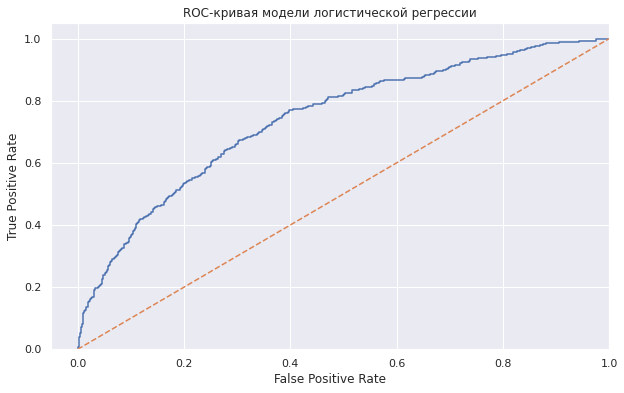

ROC-AUC score модели логистической регрессии = 0.740


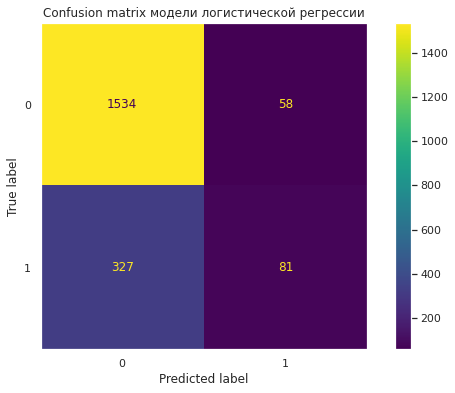

In [18]:
r_con_mat_display(features_valid, target_valid, predicted_valid, 'логистической регрессии')

In [19]:
# Воспользуемся моделью случайного леса, выполним поиск лучшей глубины с количеством деревьев 20
best_result = 0
best_depth = 0
print('Модель случайного леса с количеством деревьев = 20:')
for depth in range(1, 21):
    model = RandomForestClassifier(random_state=11363, n_estimators=20, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    print('Глубина = {:2.0f} | f1-мера = {:.3f}'.format(depth, result))
    if result > best_result:
        best_result = result
        best_depth = depth
print(f'Лучший показатель f1-меры равный {best_result:.3f} достигается при глубине {best_depth}')

Модель случайного леса с количеством деревьев = 20:
Глубина =  1 | f1-мера = 0.000
Глубина =  2 | f1-мера = 0.115
Глубина =  3 | f1-мера = 0.221
Глубина =  4 | f1-мера = 0.359
Глубина =  5 | f1-мера = 0.482
Глубина =  6 | f1-мера = 0.486
Глубина =  7 | f1-мера = 0.499
Глубина =  8 | f1-мера = 0.523
Глубина =  9 | f1-мера = 0.525
Глубина = 10 | f1-мера = 0.535
Глубина = 11 | f1-мера = 0.532
Глубина = 12 | f1-мера = 0.545
Глубина = 13 | f1-мера = 0.534
Глубина = 14 | f1-мера = 0.544
Глубина = 15 | f1-мера = 0.553
Глубина = 16 | f1-мера = 0.516
Глубина = 17 | f1-мера = 0.541
Глубина = 18 | f1-мера = 0.546
Глубина = 19 | f1-мера = 0.519
Глубина = 20 | f1-мера = 0.544
Лучший показатель f1-меры равный 0.553 достигается при глубине 15


In [20]:
# Выполним поиск наилучшего количества решающих деревьев c наилучшей глубиной 15

best_model = None
best_result = 0
best_est = 0
print(f'Модель случайного леса с глубиной {best_depth}:')
for est in range(20, 201, 20):
    model = RandomForestClassifier(random_state=11363, n_estimators=est, max_depth=best_depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    print('Количество деревьев = {:3.0f} | f1-мера = {:.3f}'.format(est, result))
    if result > best_result:
        best_result = result
        best_est = est
        best_model = model
print(f'Лучший показатель f1-меры равный {best_result:.3f} достигается при количестве деревьев {best_est}')

Модель случайного леса с глубиной 15:
Количество деревьев =  20 | f1-мера = 0.553
Количество деревьев =  40 | f1-мера = 0.557
Количество деревьев =  60 | f1-мера = 0.557
Количество деревьев =  80 | f1-мера = 0.560
Количество деревьев = 100 | f1-мера = 0.552
Количество деревьев = 120 | f1-мера = 0.562
Количество деревьев = 140 | f1-мера = 0.557
Количество деревьев = 160 | f1-мера = 0.553
Количество деревьев = 180 | f1-мера = 0.564
Количество деревьев = 200 | f1-мера = 0.558
Лучший показатель f1-меры равный 0.564 достигается при количестве деревьев 180


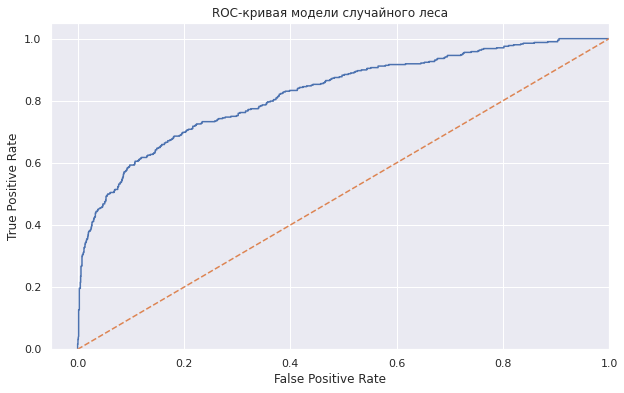

ROC-AUC score модели случайного леса = 0.824


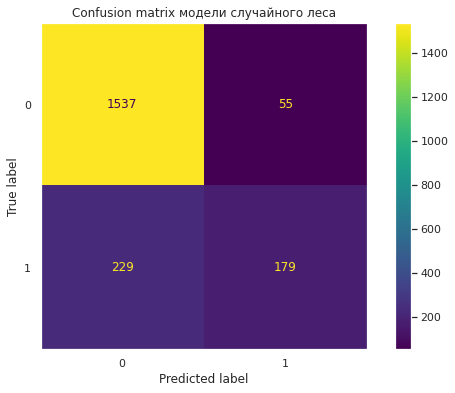

In [21]:
r_con_mat_display(features_valid, target_valid, predicted_valid, 'случайного леса')

**Баланс смещён в пользу отрицательных классов, без учёта дибсаланса лучше всего себя показывает модель случайного леса, F1 = 0.56.**

## Борьба с дисбалансом

Сконцентрируемся на модели случайного леса с использованием различных техник борьбы с дисбалансом

In [22]:
# Воспользуемся моделью случайного леса, выполним поиск лучшей глубины с количеством деревьев 20 и техникой взвешивания классов

best_result = 0
best_depth = 0

print('Модель случайного леса с количеством деревьев = 20:')
for depth in range(1, 21):
    model = RandomForestClassifier(random_state=11363, n_estimators=20, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    print('Глубина = {:2.0f} | f1-мера = {:.3f}'.format(depth, result))
    if result > best_result:
        best_result = result
        best_depth = depth
        
print(f'Лучший показатель f1-меры равный {best_result:.3f} достигается при глубине {best_depth}')

Модель случайного леса с количеством деревьев = 20:
Глубина =  1 | f1-мера = 0.480
Глубина =  2 | f1-мера = 0.509
Глубина =  3 | f1-мера = 0.520
Глубина =  4 | f1-мера = 0.539
Глубина =  5 | f1-мера = 0.551
Глубина =  6 | f1-мера = 0.561
Глубина =  7 | f1-мера = 0.585
Глубина =  8 | f1-мера = 0.571
Глубина =  9 | f1-мера = 0.584
Глубина = 10 | f1-мера = 0.580
Глубина = 11 | f1-мера = 0.581
Глубина = 12 | f1-мера = 0.575
Глубина = 13 | f1-мера = 0.568
Глубина = 14 | f1-мера = 0.557
Глубина = 15 | f1-мера = 0.551
Глубина = 16 | f1-мера = 0.560
Глубина = 17 | f1-мера = 0.520
Глубина = 18 | f1-мера = 0.519
Глубина = 19 | f1-мера = 0.507
Глубина = 20 | f1-мера = 0.519
Лучший показатель f1-меры равный 0.585 достигается при глубине 7


In [23]:
# Выполним поиск наилучшего количества решающих деревьев c наилучшей глубиной с примененим взвешивания классов

best_model = None
best_result = 0
best_est = 0

print(f'Модель случайного леса с глубиной {best_depth}:')
for est in range(20, 201, 20):
    model = RandomForestClassifier(random_state=11363, n_estimators=est, max_depth=best_depth, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    print('Количество деревьев = {:3.0f} | f1-мера = {:.3f}'.format(est, result))
    if result > best_result:
        best_result = result
        best_est = est
        best_model = model

model = best_model
print(f'Лучший показатель f1-меры равный {best_result:.3f} достигается при количестве деревьев {best_est}')

Модель случайного леса с глубиной 7:
Количество деревьев =  20 | f1-мера = 0.585
Количество деревьев =  40 | f1-мера = 0.593
Количество деревьев =  60 | f1-мера = 0.587
Количество деревьев =  80 | f1-мера = 0.587
Количество деревьев = 100 | f1-мера = 0.590
Количество деревьев = 120 | f1-мера = 0.586
Количество деревьев = 140 | f1-мера = 0.591
Количество деревьев = 160 | f1-мера = 0.588
Количество деревьев = 180 | f1-мера = 0.589
Количество деревьев = 200 | f1-мера = 0.588
Лучший показатель f1-меры равный 0.593 достигается при количестве деревьев 40


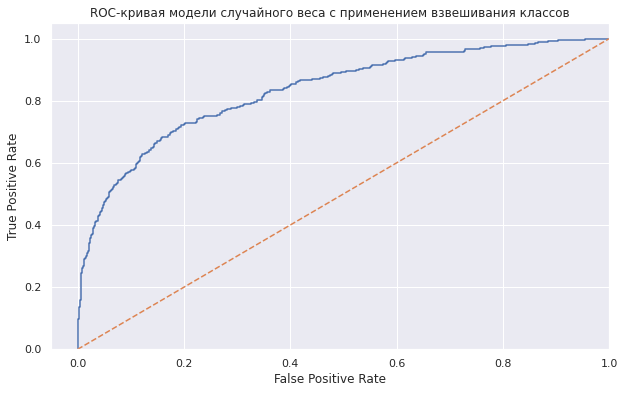

ROC-AUC score модели случайного веса с применением взвешивания классов = 0.834


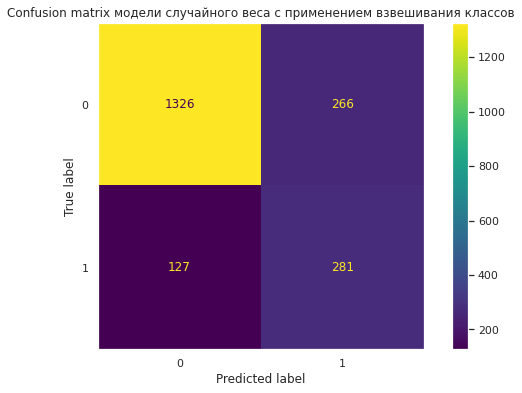

In [24]:
r_con_mat_display(features_valid, target_valid, predicted_valid, 'случайного веса с применением взвешивания классов')

In [25]:
# Воспользуемся техникой upsample

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=11363)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [26]:
# Применим технику downsample

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=11363)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=11363)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=11363)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [27]:
# Воспользуемся моделью случайного леса, выполним поиск лучшей глубины с количеством деревьев 20 + upsampled

best_result = 0
best_depth = 0

print('`Upsampled` Модель случайного леса с количеством деревьев = 20:')
for depth in range(1, 21):
    model = RandomForestClassifier(random_state=11363, n_estimators=20, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    print('Глубина = {:2.0f} | f1-мера = {:.3f}'.format(depth, result))
    if result > best_result:
        best_result = result
        best_depth = depth
        
print(f'`Upsampled` Лучший показатель f1-меры равный {best_result:.3f} достигается при глубине {best_depth}')

`Upsampled` Модель случайного леса с количеством деревьев = 20:
Глубина =  1 | f1-мера = 0.476
Глубина =  2 | f1-мера = 0.507
Глубина =  3 | f1-мера = 0.531
Глубина =  4 | f1-мера = 0.545
Глубина =  5 | f1-мера = 0.547
Глубина =  6 | f1-мера = 0.569
Глубина =  7 | f1-мера = 0.572
Глубина =  8 | f1-мера = 0.572
Глубина =  9 | f1-мера = 0.582
Глубина = 10 | f1-мера = 0.585
Глубина = 11 | f1-мера = 0.579
Глубина = 12 | f1-мера = 0.571
Глубина = 13 | f1-мера = 0.592
Глубина = 14 | f1-мера = 0.591
Глубина = 15 | f1-мера = 0.578
Глубина = 16 | f1-мера = 0.548
Глубина = 17 | f1-мера = 0.555
Глубина = 18 | f1-мера = 0.557
Глубина = 19 | f1-мера = 0.558
Глубина = 20 | f1-мера = 0.560
`Upsampled` Лучший показатель f1-меры равный 0.592 достигается при глубине 13


In [28]:
# Выполним поиск наилучшего количества решающих деревьев c наилучшей глубиной + upsampled

best_model_rf_up = None
best_result = 0
best_est = 0

print(f'`Upsampled` Модель случайного леса с глубиной {best_depth}:')
for est in range(20, 201, 20):
    model = RandomForestClassifier(random_state=11363, n_estimators=est, max_depth=best_depth)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    print('Количество деревьев = {:3.0f} | f1-мера = {:.3f}'.format(est, result))
    if result > best_result:
        best_result = result
        best_est = est
        best_model_rf_up = model
        
print(f'`Upsampled` Лучший показатель f1-меры равный {best_result:.3f} достигается при количестве деревьев {best_est}')

model = best_model_rf_up

`Upsampled` Модель случайного леса с глубиной 13:
Количество деревьев =  20 | f1-мера = 0.592
Количество деревьев =  40 | f1-мера = 0.607
Количество деревьев =  60 | f1-мера = 0.592
Количество деревьев =  80 | f1-мера = 0.591
Количество деревьев = 100 | f1-мера = 0.602
Количество деревьев = 120 | f1-мера = 0.592
Количество деревьев = 140 | f1-мера = 0.591
Количество деревьев = 160 | f1-мера = 0.596
Количество деревьев = 180 | f1-мера = 0.595
Количество деревьев = 200 | f1-мера = 0.598
`Upsampled` Лучший показатель f1-меры равный 0.607 достигается при количестве деревьев 40


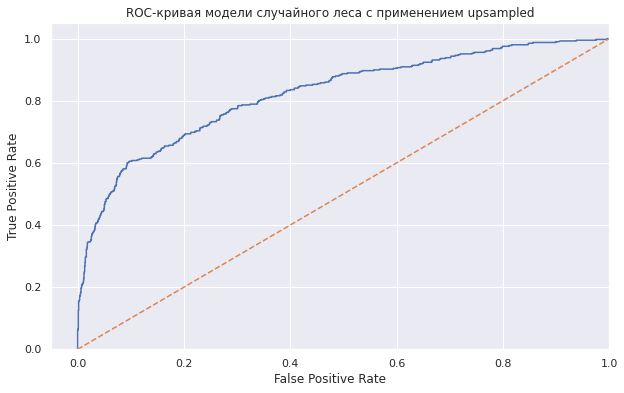

ROC-AUC score модели случайного леса с применением upsampled = 0.822


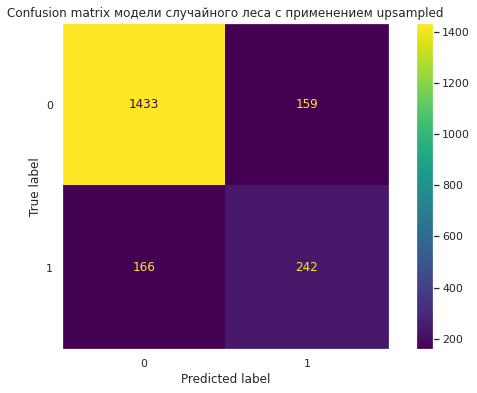

In [29]:
r_con_mat_display(features_valid, target_valid, predicted_valid, 'случайного леса с применением upsampled')

In [30]:
# Воспользуемся моделью случайного леса, выполним поиск лучшей глубины с количеством деревьев 20 + downsampled

best_result = 0
best_depth = 0

print('`Downsampled` Модель случайного леса с количеством деревьев = 20:')
for depth in range(1, 21):
    model = RandomForestClassifier(random_state=11363, n_estimators=20, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    print('Глубина = {:2.0f} | f1-мера = {:.3f}'.format(depth, result))
    if result > best_result:
        best_result = result
        best_depth = depth
        
print(f'`Downsampled` Лучший показатель f1-меры равный {best_result:.3f} достигается при глубине {best_depth}')

`Downsampled` Модель случайного леса с количеством деревьев = 20:
Глубина =  1 | f1-мера = 0.476
Глубина =  2 | f1-мера = 0.507
Глубина =  3 | f1-мера = 0.531
Глубина =  4 | f1-мера = 0.545
Глубина =  5 | f1-мера = 0.547
Глубина =  6 | f1-мера = 0.569
Глубина =  7 | f1-мера = 0.572
Глубина =  8 | f1-мера = 0.572
Глубина =  9 | f1-мера = 0.582
Глубина = 10 | f1-мера = 0.585
Глубина = 11 | f1-мера = 0.579
Глубина = 12 | f1-мера = 0.571
Глубина = 13 | f1-мера = 0.592
Глубина = 14 | f1-мера = 0.591
Глубина = 15 | f1-мера = 0.578
Глубина = 16 | f1-мера = 0.548
Глубина = 17 | f1-мера = 0.555
Глубина = 18 | f1-мера = 0.557
Глубина = 19 | f1-мера = 0.558
Глубина = 20 | f1-мера = 0.560
`Downsampled` Лучший показатель f1-меры равный 0.592 достигается при глубине 13


In [31]:
## Выполним поиск наилучшего количества решающих деревьев c наилучшей глубиной + downsampled

best_model_rf_down = None
best_result = 0
best_est = 0

print(f'`Downsampled` Модель случайного леса с глубиной {best_depth}:')
for est in range(20, 201, 20):
    model = RandomForestClassifier(random_state=11363, n_estimators=est, max_depth=best_depth)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    print('Количество деревьев = {:3.0f} | f1-мера = {:.3f}'.format(est, result))
    if result > best_result:
        best_result = result
        best_est = est
        best_model_rf_down = model
print(f'`Downsampled` Лучший показатель f1-меры равный {best_result:.3f} достигается при количестве деревьев {best_est}')

model = best_model_rf_down

`Downsampled` Модель случайного леса с глубиной 13:
Количество деревьев =  20 | f1-мера = 0.592
Количество деревьев =  40 | f1-мера = 0.607
Количество деревьев =  60 | f1-мера = 0.592
Количество деревьев =  80 | f1-мера = 0.591
Количество деревьев = 100 | f1-мера = 0.602
Количество деревьев = 120 | f1-мера = 0.592
Количество деревьев = 140 | f1-мера = 0.591
Количество деревьев = 160 | f1-мера = 0.596
Количество деревьев = 180 | f1-мера = 0.595
Количество деревьев = 200 | f1-мера = 0.598
`Downsampled` Лучший показатель f1-меры равный 0.607 достигается при количестве деревьев 40


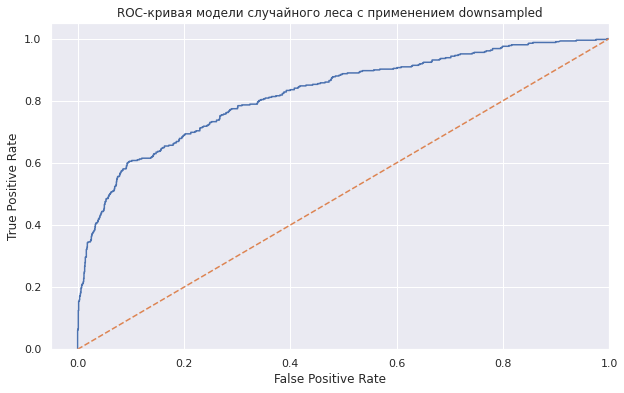

ROC-AUC score модели случайного леса с применением downsampled = 0.822


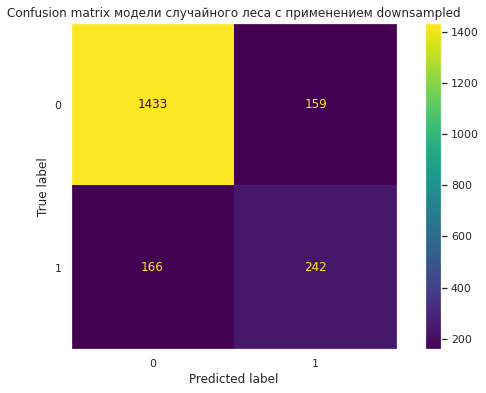

In [32]:
r_con_mat_display(features_valid, target_valid, predicted_valid, 'случайного леса с применением downsampled')

In [33]:
smote = SMOTE(random_state=11363)
features_sm, target_sm = smote.fit_resample(features_train, target_train)

In [34]:
features_train.shape, features_sm.shape

((6000, 11), (9556, 11))

In [35]:
target_train.value_counts(normalize=True)

0    0.796333
1    0.203667
Name: Exited, dtype: float64

In [36]:
target_sm.value_counts(normalize=True)

0    0.5
1    0.5
Name: Exited, dtype: float64

In [37]:
# Воспользуемся моделью случайного леса, выполним поиск лучшей глубины с количеством деревьев 20 + SMOTE

best_result = 0
best_depth = 0

print('`SMOTE` Модель случайного леса с количеством деревьев = 20:')
for depth in range(1, 21):
    model = RandomForestClassifier(random_state=11363, n_estimators=20, max_depth=depth)
    model.fit(features_sm, target_sm)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    print('Глубина = {:2.0f} | f1-мера = {:.3f}'.format(depth, result))
    if result > best_result:
        best_result = result
        best_depth = depth
        
print(f'`SMOTE` Лучший показатель f1-меры равный {best_result:.3f} достигается при глубине {best_depth}')

`SMOTE` Модель случайного леса с количеством деревьев = 20:
Глубина =  1 | f1-мера = 0.460
Глубина =  2 | f1-мера = 0.516
Глубина =  3 | f1-мера = 0.521
Глубина =  4 | f1-мера = 0.559
Глубина =  5 | f1-мера = 0.557
Глубина =  6 | f1-мера = 0.565
Глубина =  7 | f1-мера = 0.568
Глубина =  8 | f1-мера = 0.572
Глубина =  9 | f1-мера = 0.581
Глубина = 10 | f1-мера = 0.590
Глубина = 11 | f1-мера = 0.583
Глубина = 12 | f1-мера = 0.583
Глубина = 13 | f1-мера = 0.580
Глубина = 14 | f1-мера = 0.585
Глубина = 15 | f1-мера = 0.580
Глубина = 16 | f1-мера = 0.571
Глубина = 17 | f1-мера = 0.585
Глубина = 18 | f1-мера = 0.555
Глубина = 19 | f1-мера = 0.567
Глубина = 20 | f1-мера = 0.562
`SMOTE` Лучший показатель f1-меры равный 0.590 достигается при глубине 10


In [38]:
## Выполним поиск наилучшего количества решающих деревьев c наилучшей глубиной + SMOTE

best_model_rf_smote = None
best_result = 0
best_est = 0

print(f'`SMOTE` Модель случайного леса с глубиной {best_depth}:')
for est in range(20, 201, 20):
    model = RandomForestClassifier(random_state=11363, n_estimators=est, max_depth=best_depth)
    model.fit(features_sm, target_sm)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    print('Количество деревьев = {:3.0f} | f1-мера = {:.3f}'.format(est, result))
    if result > best_result:
        best_result = result
        best_est = est
        best_model_rf_smote = model
print(f'`SMOTE` Лучший показатель f1-меры равный {best_result:.3f} достигается при количестве деревьев {best_est}')

model = best_model_rf_smote

`SMOTE` Модель случайного леса с глубиной 10:
Количество деревьев =  20 | f1-мера = 0.590
Количество деревьев =  40 | f1-мера = 0.582
Количество деревьев =  60 | f1-мера = 0.588
Количество деревьев =  80 | f1-мера = 0.591
Количество деревьев = 100 | f1-мера = 0.585
Количество деревьев = 120 | f1-мера = 0.584
Количество деревьев = 140 | f1-мера = 0.592
Количество деревьев = 160 | f1-мера = 0.587
Количество деревьев = 180 | f1-мера = 0.596
Количество деревьев = 200 | f1-мера = 0.593
`SMOTE` Лучший показатель f1-меры равный 0.596 достигается при количестве деревьев 180


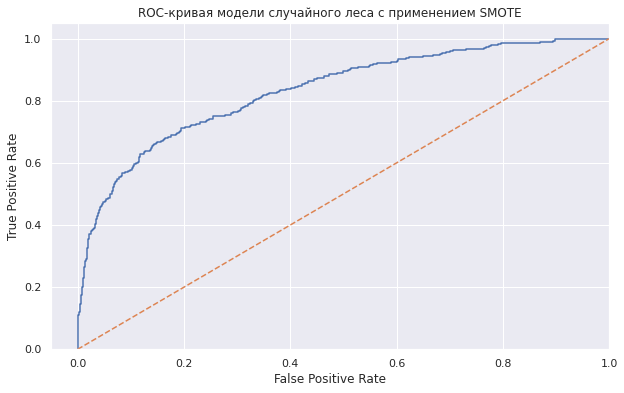

ROC-AUC score модели случайного леса с применением SMOTE = 0.832


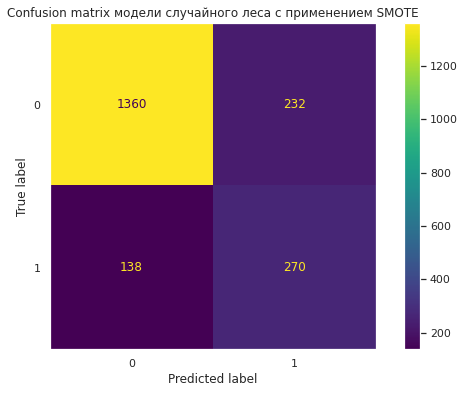

In [39]:
r_con_mat_display(features_valid, target_valid, predicted_valid, 'случайного леса с применением SMOTE')

**Наилучшим образом показала себя модель случайного леса с применением техники upsample/downsample с максимальной глубиной 13 и количеством деревьев 40.  
F1-мера ~ 0.607  
ROC-AUC = 0.822**

## Тестирование модели

In [40]:
# Проведём обучение модели на совмещённой выборке (тренировочная + валидационная)
features_tv = pd.concat([features_train] + [features_valid])
target_tv = pd.concat([target_train] + [target_valid])

In [41]:
features_tv_upsampled, target_tv_upsampled = upsample(features_tv, target_tv, 4)

In [42]:
model = best_model_rf_up
model.fit(features_tv_upsampled, target_tv_upsampled)
predicted_test = model.predict(features_test)
result = f1_score(target_test, predicted_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print(f'Модель случайного леса на тестовой выборке показывает F1-меру = {result:.3f}')

Модель случайного леса на тестовой выборке показывает F1-меру = 0.637


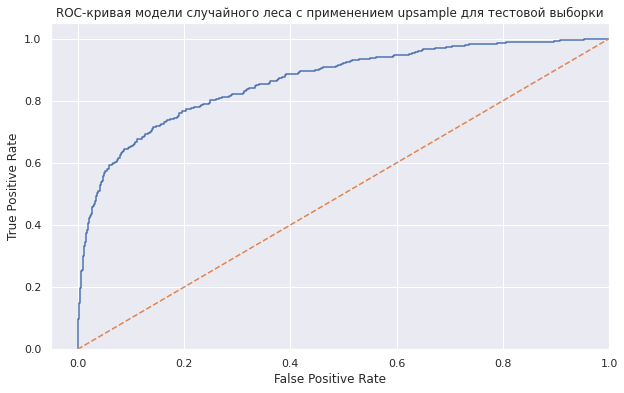

ROC-AUC score модели случайного леса с применением upsample для тестовой выборки = 0.863


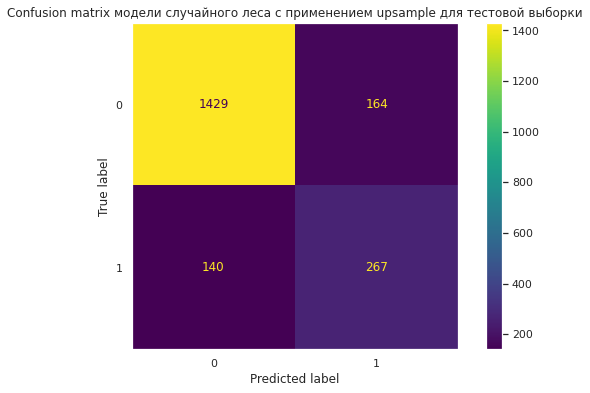

In [43]:
r_con_mat_display(features_test, target_test, predicted_test,'случайного леса с применением upsample для тестовой выборки')

In [44]:
features_tv_sm, target_tv_sm = smote.fit_resample(features_tv, target_tv)

In [45]:
model = best_model_rf_smote
model.fit(features_tv_sm, target_tv_sm)
predicted_test = model.predict(features_test)
result = f1_score(target_test, predicted_test)

print(f'Модель случайного леса + SMOTE на тестовой выборке показывает F1-меру = {result:.3f}')

Модель случайного леса + SMOTE на тестовой выборке показывает F1-меру = 0.645


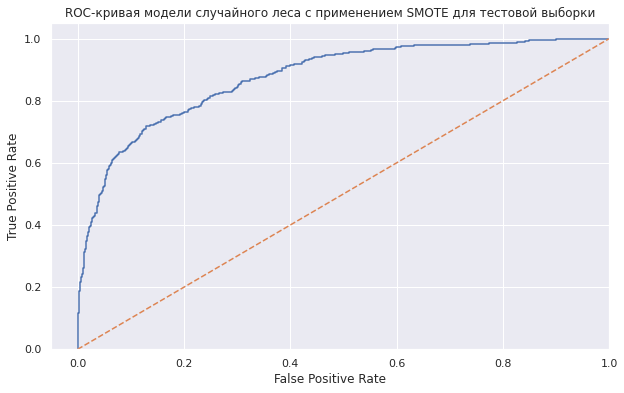

ROC-AUC score модели случайного леса с применением SMOTE для тестовой выборки = 0.876


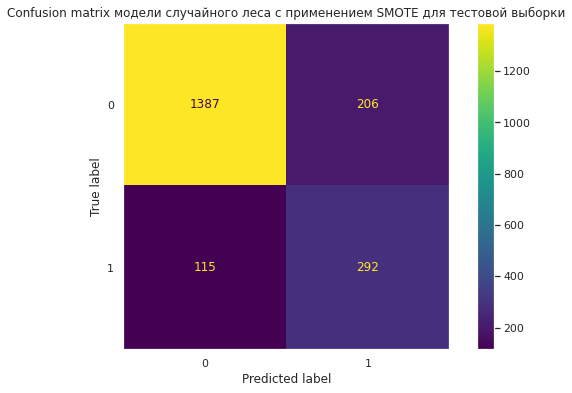

In [46]:
r_con_mat_display(features_test, target_test, predicted_test, 'случайного леса с применением SMOTE для тестовой выборки')

In [47]:
# Обучим модель логистической регрессии + smote

model = LogisticRegression(random_state=11363, solver='liblinear')
model.fit(features_tv_sm, target_tv_sm)
predicted_test = model.predict(features_test)
print(f'F1-мера =  {f1_score(target_test, predicted_valid):.3f}')

F1-мера =  0.244


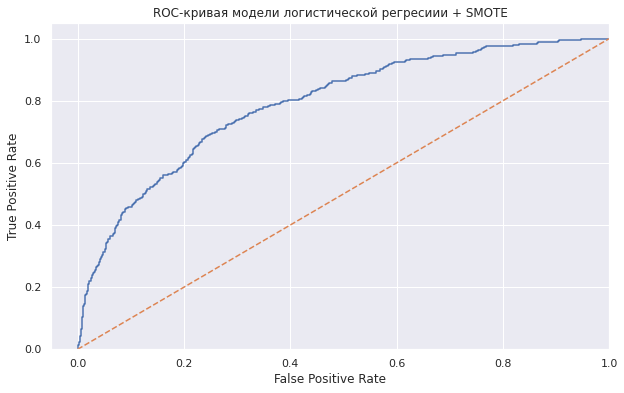

ROC-AUC score модели логистической регресиии + SMOTE = 0.789


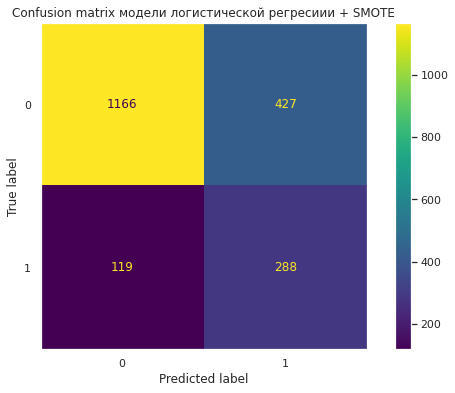

In [48]:
r_con_mat_display(features_test, target_test, predicted_test, 'логистической регресиии + SMOTE' )

In [50]:
# Проверим модель на адекватность
dummy_clsf = DummyClassifier(strategy='most_frequent')
dummy_clsf.fit(features_test, target_test)
dummy_clsf.predict(features_test)
result_dummy = dummy_clsf.score(features_test, target_test)
result_best = best_model.score(features_test, target_test)
print(f'Константная модель имеет Accuracy: {result_dummy}')
print(f'Лучшая модель имеет Accuracy: {result_best}')

Константная модель имеет Accuracy: 0.7965
Лучшая модель имеет Accuracy: 0.8235


## Вывод  
В нашем распоряжении данные банковских клиентов, часть из которых расторлга отношения с банком.
Задача - спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

С учётом необходимости построения модели классификации для предсказания оттока, данные были разделены на три выборки (train, validation, test) с учётом стратификации. Было протестировано модели логистической регрессии и случайного леса, лучшие результаты продемонстрировала модель случайного леса.

Эффективнее всего с дисбалансом удалось бороться методом **SMOTE**.  
На валидационных данных наилучший уровень f1-меры 0.596 показала модель RF с количеством деревьев 180 и максимальной глубиной 10.  
После чего мы обучили модель на выборке train+validation, показатель f1-меры для тестовой выборки составил 0.645.
ROC-AUC score =  0.876
Точность модели составила 0.824, что превышает точность dummy модели 0.797.

**Построенную модель рекомендуется использовать для превентивного противодействия оттоку клиентов путём маркетинговых инструментов.**